In [1]:
import sklearn
print('This must be at least version 0.20.0')
print('If it is not, you must upgrade conda and scikit-learn.')
sklearn.__version__

This must be at least version 0.20.0
If it is not, you must upgrade conda and scikit-learn.


'0.20.0'

In [2]:
import pandas as pd
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import os
import seaborn as sns
from IPython.display import display
from jupyterthemes import jtplot
jtplot.style()

In [3]:
def load_single(file, data_path='data/'):
    file = os.path.join(data_path, file)
    df = pd.read_csv(file)
    return df
def load_multiple(file_list, data_path='data/'):
    for file in file_list:
        csv_path = os.path.join(data_path, file)
        yield pd.read_csv(csv_path)
coaches, stadiums = load_multiple(('Coaches8.csv', 'stadiums.csv'))
display(coaches.head(3), stadiums.head(3))

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout
0,Air Force,Mt. West,Troy Calhoun,885000,885000,247000,--,$0,--
1,Akron,MAC,Terry Bowden,"$411,000","$412,500","$225,000","$50,000",$0,"$688,500"
2,Alabama,SEC,Nick Saban,"$8,307,000","$8,307,000","$1,100,000","$500,000",$0,"$33,600,000"


,stadium,city,state,team,conference,capacity,built,expanded,div,latitude,longitude
0,Michigan Stadium,Ann Arbor,MI,Michigan,Big Ten,107601,1927,2015,fbs,42.265869,-83.748726
1,Beaver Stadium,University Park,PA,Penn State,Big Ten,106572,1960,2001,fbs,40.812153,-77.856202
2,Ohio Stadium,Columbus,OH,Ohio State,Big Ten,104944,1922,2014,fbs,40.001686,-83.019728


In [4]:
coaches.columns = list(coaches.columns.str.lower())
stadiums.rename(columns={'team': 'school'}, inplace=True)

In [5]:
stads = stadiums.drop(['expanded', 'conference', 'div'], axis=1)
display('1) Dropped for no coach information', coaches.loc[coaches.totalpay == '--'].school)
coach = coaches.drop(coaches.loc[coaches.totalpay == '--'].index)
coach = coach.drop('assistantpay', axis=1) 
def impute_missing_stads(coach_v, school):
    coach.loc[coach.coach == coach_v, 'school']= school
coach_missing_schools = {
    'Dana Dimel': 'UTEP',
    'Frank Wilson': 'UTSA',
    'Gary Patterson': 'TCU',
    'Jay Hopson': 'Southern Miss',
    'Charlie Strong': 'USF',
    'Rod Carey': 'NIU',
    'Dave Doeren': 'NC State',
    'Tony Sanchez': 'UNLV',
    'Chuck Martin': 'Miami (OH)',
    'Mark Richt': 'Miami',
    'Mark Whipple': 'UMass',
    'Turner Gill': 'Liberty Flames',
    'Butch Davis': 'FIU',
    'Joe Moglia': 'Coastal Carolina Chanticleers',
    'Josh Heupel': 'UCF'
}
for k, v in coach_missing_schools.items():
    impute_missing_stads(k, v)
coach_stads = pd.merge(coach, stads, on='school', how='left')
display('2) Missing stadium information', coach_stads.loc[coach_stads.stadium.isna()])

'1) Dropped for no coach information'

12                 Baylor
16          Brigham Young
91                   Rice
99     Southern Methodist
103                Temple
Name: school, dtype: object

'2) Missing stadium information'

,school,conference,coach,schoolpay,totalpay,bonus,bonuspaid,buyout,stadium,city,state,capacity,built,latitude,longitude
3,Alabama at Birmingham,C-USA,Bill Clark,"$900,000","$900,000","$950,000","$165,471","$3,847,500",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
coach_stads.loc[coach_stads.coach == 'Bill Clark', 'city'] = 'Birmingham'
coach_stads.loc[coach_stads.coach == 'Bill Clark', 'stadium'] = 'Legion'
coach_stads.loc[coach_stads.coach == 'Bill Clark', 'capacity'] = 71594
coach_stads.loc[coach_stads.coach == 'Bill Clark', 'built'] = 1927
coach_stads.loc[coach_stads.coach == 'Bill Clark', 'latitude'] = 33.511389
coach_stads.loc[coach_stads.coach == 'Bill Clark', 'longitude'] = -86.842778
coach_stads.loc[coach_stads.coach == 'Bill Clark', 'state'] = 'AL'

In [7]:

display(coach_stads.loc[coach_stads.totalpay == coach_stads.totalpay.max()])

,school,conference,coach,schoolpay,totalpay,bonus,bonuspaid,buyout,stadium,city,state,capacity,built,latitude,longitude
9,Army,Ind.,Jeff Monken,932521,932521,--,--,--,Michie Stadium,West Point,NY,38000.0,1924.0,41.38708,-73.964081


In [8]:
def clean_numbers(series):
    series = series.replace('$', '')
    series = series.replace(',', '')
    series = series.replace('--', '0')
    return series

series_convert = [
    'totalpay',
    'schoolpay',
    'bonus',
    'bonuspaid',
    'buyout'
]
for series in series_convert:
    coach_stads[series] = coach_stads[series].apply(clean_numbers)
    coach_stads[series] = coach_stads[series].astype(int)

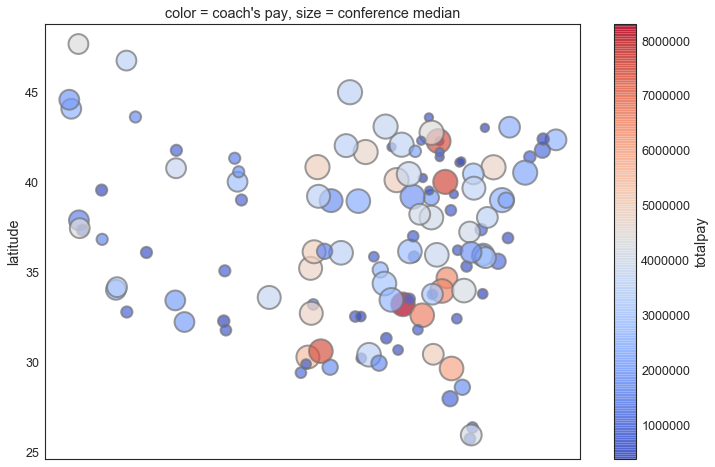

In [9]:
sns.set_style('white')
coach_plot = coach_stads.drop(coach_stads.loc[coach_stads.latitude == coach_stads.latitude.min()].index)
coach_plot = coach_plot.assign(conf_med=lambda x: x.groupby('conference')['totalpay'].transform(np.median))
coach_plot.plot(kind='scatter', x='longitude', y='latitude',
                c='totalpay', cmap=plt.get_cmap('coolwarm'), colorbar=True, alpha=0.7,
                s=coach_plot.conf_med / 7000,
                edgecolor='.45',
                linewidth=2,
                figsize=(12,8)
               )
plt.title('color = coach\'s pay, size = conference median')
plt.show()

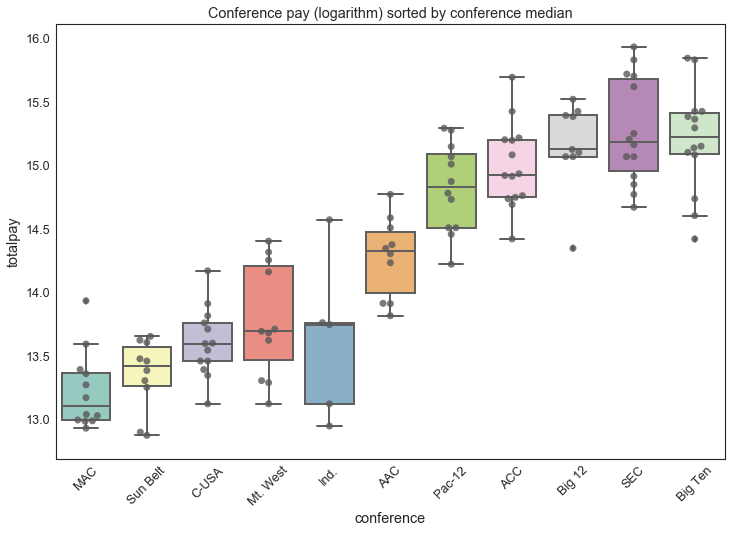

In [10]:
sns.set_palette('Set3')
sns.set_style('white')
coach_plot = coach_plot.sort_values(by='conf_med')
coach_plot.totalpay = np.log(coach_stads.totalpay)
plt.figure(figsize=(12, 8))
sns.boxplot(x='conference', y='totalpay', data=coach_plot, linewidth=2)
sns.swarmplot(x='conference', y='totalpay', data=coach_plot, color='.35', size=7, alpha=.8)
plt.xticks(rotation=45)
plt.title('Conference pay (logarithm) sorted by conference median')
plt.show()

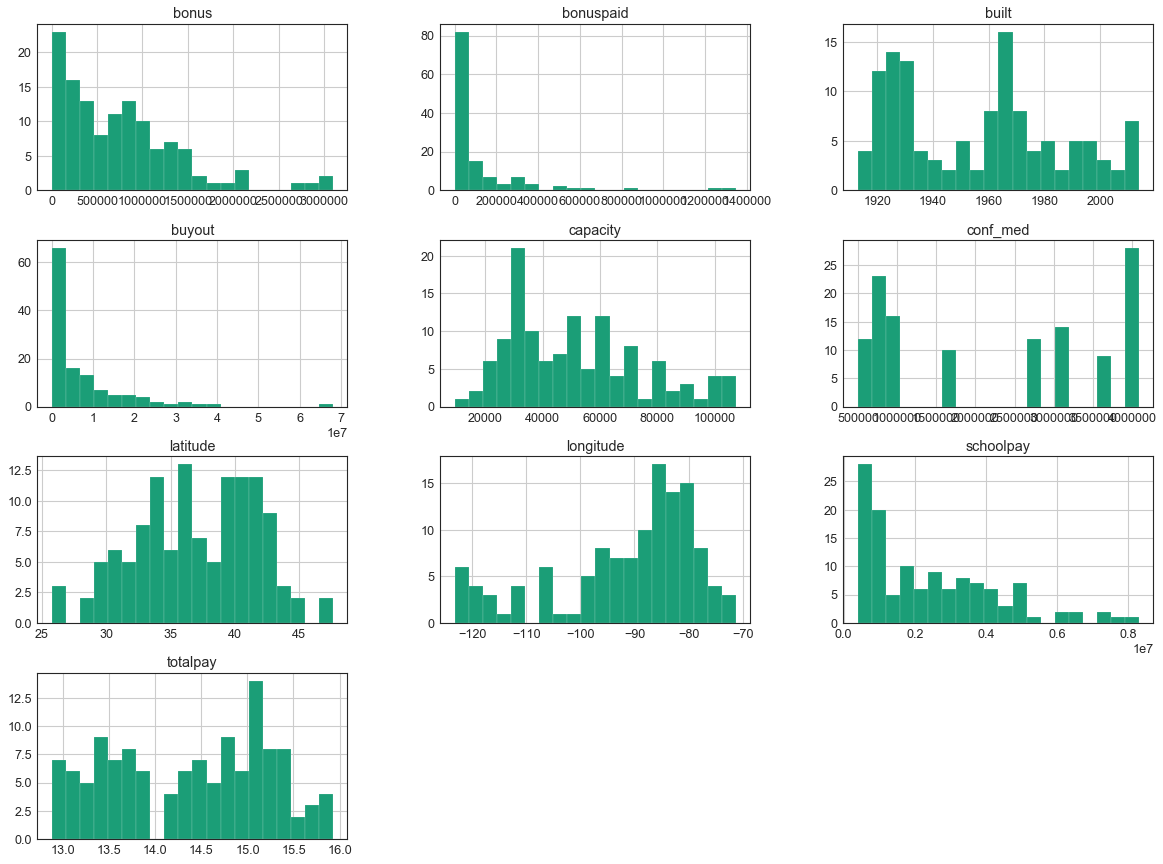

In [11]:
sns.set_palette('Dark2')
sns.set_style('white') 
coach_plot.hist(bins=20, figsize=(20, 15))
plt.show()

In [12]:
grad_rates = pd.read_csv('data/30022-0004-Data.tsv', delimiter='\t')
columns = list(grad_rates)
for column in columns:
    if column == 'SCL_NAME' or column == 'SCL_HBCU':
        continue
    if '2006' not in column or '_SB' in column:
        grad_rates = grad_rates.drop(column, axis=1)
grad_rates.rename(columns={'SCL_NAME': 'school'}, inplace=True)
grad_rates.rename(columns={'SCL_HBCU': 'hbcu'}, inplace=True)
grad_rates.hbcu = grad_rates.hbcu.where(grad_rates.hbcu == 1, 0)
grad_rates.columns = list(grad_rates.columns.str.lower())
def clean_names(x):
    x = x.replace('The University of', '')
    x = x.replace('University of', '')
    if x.endswith('-Main Campus'):
        x = x.replace('-Main Campus', '')
    if x.endswith('University'):
        x = x.replace('University', '')
    x = x.strip()
    return x
grad_rates.school = grad_rates.school.apply(clean_names)
easies = [
    'Tulane',
    'Rutgers',
    'Pittsburgh',
    'Kent State',
    'Buffalo',
    'Air Force',
    'Middle Tennessee',
    'Akron',
    'Colorado State',
    'Hawaii',
    'Minnesota',
    'Charlotte',
    'Arizona State',
]
for easy in easies:
    grad_rates.loc[grad_rates.school.str.contains(easy), 'school'] = easy
school_map = {
    'CaliforniaState University-Bakersfield': 'California',
    'Wisconsin-Madison': 'Wisconsin',
    'California-Berkeley': 'California',
    'Texas Christian': 'TCU',
    'Texas at El Paso': 'UTEP',
    'Texas at Austin': 'Texas',
    'Virginia Polytechnic Institute and State': 'Virginia Tech',
    'Texas A & M University-College Station': 'Texas A&M',
    'California State University-Fresno': 'Fresno State',
    'Texas at San Antonio': 'UTSA',
    'Washington-Seattle Campus': 'Washington',
    'California-Los Angeles': 'UCLA',
    'Reno': 'Nevada',
    'Las Vegas': 'UNLV',
    'Chapel Hill': 'North Carolina',
    'Northern Illinois': 'NIU',
    'Louisiana at Lafayette': 'Louisiana-Lafayette',
    'Miami University-Oxford': 'Miami (OH)',
    'Liberty': 'Liberty Flames',
    'Naval': 'Navy',
    'Military Academy': 'Army',
    'Bowling Green': 'Bowling Green',
    'Southern Mississippi': 'Southern Miss',
    'South Florida': 'USF',
    'Central Florida': 'UCF',
    'Florida International': 'FIU',
    'Coastal': 'Coastal Carolina Chanticleers',
    'Colorado Boulder': 'Colorado',
    'Georgia Institute of Technology': 'Georgia Tech',
    'Champaign': 'Illinois',
    'Bloomington': 'Indiana',
    'Monroe': 'Louisiana-Monroe',
    'Louisiana State': 'LSU',
    'College Park': 'Maryland',
    'Massachusetts': 'UMass',
    'Ann Arbor': 'Michigan',
    'Missouri-Columbia': 'Missouri',
    'Nebraska': 'Nebraska',
    'Raleigh': 'NC State',
    'Norman': 'Oklahoma',
    'Knoxville': 'Tennessee',
    'Pennsylvania State': 'Penn State',
    'South Carolina-Columbia': 'South Carolina'
}
for pre, post in school_map.items():
    grad_rates.loc[grad_rates.school.str.contains(pre), 'school'] = post
grad_rates.drop(grad_rates.loc[grad_rates.school.str.contains('California ')].index, inplace=True)
grad_rates.drop(grad_rates.loc[grad_rates.school.str.contains('California-')].index, inplace=True)
commons = list(set(coach_stads.school) & set(grad_rates.school))

In [13]:
grad_stads = pd.merge(coach_stads, grad_rates, on='school', how='left')
display(coach_stads.shape)
display(grad_rates.shape)
display(grad_stads.shape)

(125, 15)

(335, 10)

(125, 24)

In [14]:
display(grad_stads.isna().sum())
grad_stads.drop(['fed_n_2006_sa', 'gsr_n_2006_sa', 'fed_rate_male_2006_sa', 'fed_rate_female_2006_sa',
                'gsr_male_2006_sa', 'gsr_female_2006_sa'], axis=1, inplace=True)
grad_stads.loc[
    grad_stads.fed_rate_2006_sa == grad_stads.fed_rate_2006_sa.min(), 'fed_rate_2006_sa'
] = grad_stads.fed_rate_2006_sa.quantile(.9)

school                     0
conference                 0
coach                      0
schoolpay                  0
totalpay                   0
bonus                      0
bonuspaid                  0
buyout                     0
stadium                    0
city                       0
state                      0
capacity                   0
built                      0
latitude                   0
longitude                  0
hbcu                       0
fed_n_2006_sa              0
fed_rate_2006_sa           0
gsr_n_2006_sa              0
gsr_2006_sa                0
fed_rate_male_2006_sa      0
fed_rate_female_2006_sa    0
gsr_male_2006_sa           0
gsr_female_2006_sa         0
dtype: int64

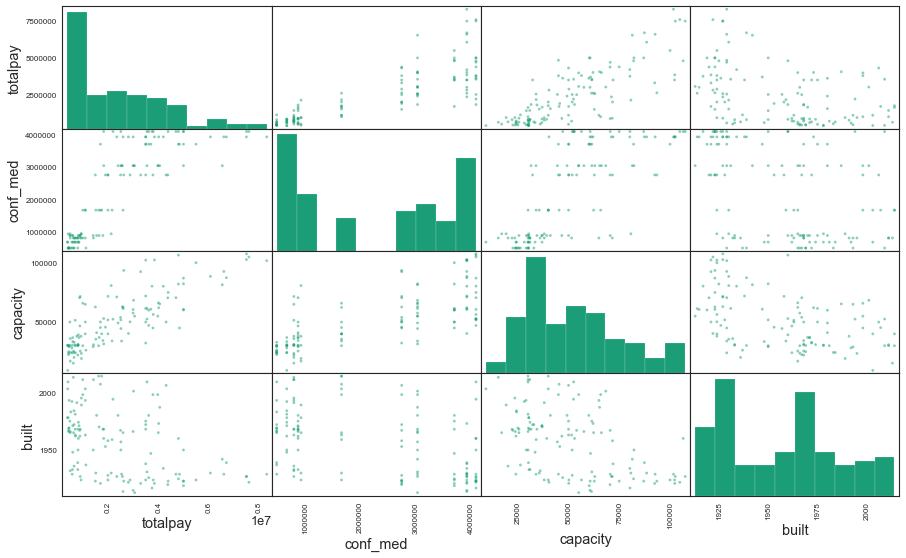

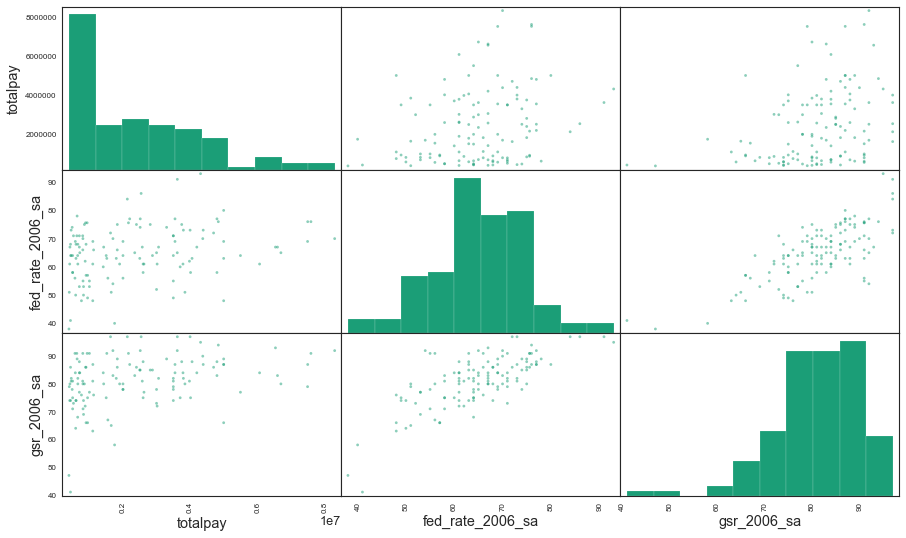

In [15]:
from pandas.plotting import scatter_matrix
attributes = list(grad_stads)
grad_stads = grad_stads.assign(conf_med=lambda x: x.groupby('conference')['totalpay'].transform(np.median))
stad_atts = ['totalpay', 'conf_med', 'capacity', 'built']
grad_atts = ['totalpay', 'fed_rate_2006_sa', 'gsr_2006_sa']
scatter_matrix(grad_stads[stad_atts], figsize=(15, 9))
scatter_matrix(grad_stads[grad_atts], figsize=(15, 9))
plt.show()

totalpay            1.000000
conf_med            0.825767
capacity            0.806247
gsr_2006_sa         0.328886
fed_rate_2006_sa    0.263095
built              -0.425159
Name: totalpay, dtype: float64

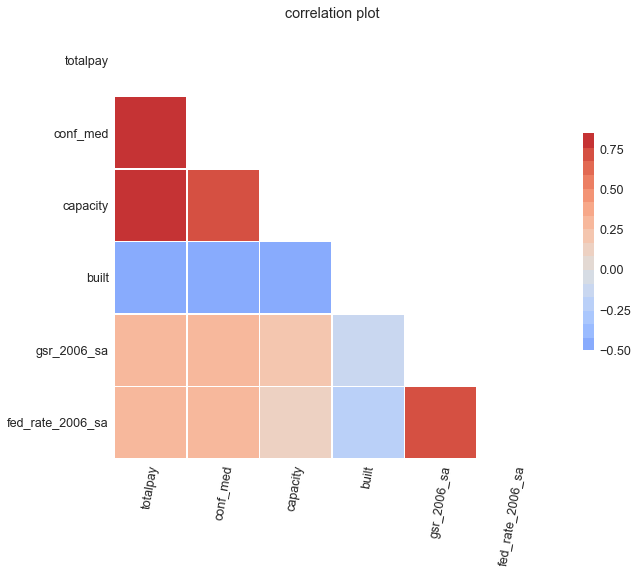

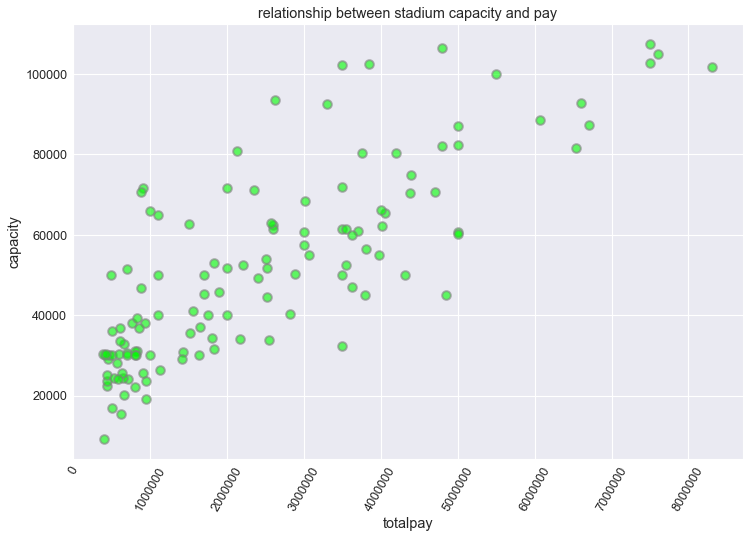

In [16]:
empiricals = [
    'totalpay', 'conf_med', 'capacity', 'built', 
    'gsr_2006_sa',
    'fed_rate_2006_sa',
]
corr_matrix = grad_stads[empiricals].corr()
display(corr_matrix['totalpay'].sort_values(ascending=False))
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.color_palette('coolwarm', 20)
plt.subplots(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.85, vmin=-.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=80)
plt.yticks(rotation=0)
plt.title('correlation plot')
plt.show()
sns.set_style('darkgrid')
grad_stads.plot(kind='scatter', x='totalpay', y='capacity', 
                c='lime', s=75, alpha=.6, edgecolor='gray', linewidth=2,
                figsize=(12,8))
plt.xticks(rotation=60)
plt.yticks(rotation=0)
plt.title('relationship between stadium capacity and pay')
plt.show()

In [17]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.utils import shuffle
model_atts = empiricals.copy()
model_atts.remove('totalpay')
y = 'totalpay~ '
X = ' + '.join(model_atts)
X = '(' + X + ')**2'
ols_model = y + X
quick_peek = shuffle(grad_stads)[:round(grad_stads.shape[0] * .7)]
peek_fit = smf.ols(ols_model, data = quick_peek).fit()
print('Model:', ols_model, '\n')
print(peek_fit.summary())

Model: totalpay~ (conf_med + capacity + built + gsr_2006_sa + fed_rate_2006_sa)**2 

                            OLS Regression Results                            
Dep. Variable:               totalpay   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     25.73
Date:                Sun, 21 Oct 2018   Prob (F-statistic):           5.33e-23
Time:                        08:51:17   Log-Likelihood:                -1311.5
No. Observations:                  88   AIC:                             2655.
Df Residuals:                      72   BIC:                             2695.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [18]:
grad_stads = grad_stads.assign(cap_fed=lambda x: x.capacity * x.fed_rate_2006_sa)
empiricals = [
    'totalpay', 
    'conf_med', 
    'capacity', 
    'built', 
    'gsr_2006_sa',
    'fed_rate_2006_sa', 
    'cap_fed',
]
corr_matrix = grad_stads[empiricals].corr()
display(corr_matrix['totalpay'].sort_values(ascending=False))

totalpay            1.000000
conf_med            0.825767
cap_fed             0.824425
capacity            0.806247
gsr_2006_sa         0.328886
fed_rate_2006_sa    0.263095
built              -0.425159
Name: totalpay, dtype: float64

In [19]:
grad_stads = grad_stads.assign(med_cat=lambda x: np.round(x['conf_med']))
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(grad_stads, grad_stads['med_cat']):
    strat_train_set = grad_stads.loc[train_index]
    strat_test_set = grad_stads.loc[test_index]
for set_ in [strat_train_set, strat_test_set]:
    set_.drop('med_cat', axis=1, inplace=True)
coaches = strat_train_set.drop('totalpay', axis=1)
coaches_label = strat_train_set.totalpay.copy()

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
cat_attributes = [
    'conference',
]
num_attributes = [
    'built',
    'conf_med',
    'cap_fed'
]
pipe = ColumnTransformer([
    ("num", StandardScaler(), num_attributes),
    ("cat", OneHotEncoder(), cat_attributes),
])
coach_prepped = pipe.fit_transform(coaches)

In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
forest_reg = RandomForestRegressor()
param_grid = [
    {'n_estimators': [500, 750, 1000], 'max_features': [8, 12]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(coach_prepped, coaches_label)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [500, 750, 1000], 'max_features': [8, 12]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [22]:
best_forest = grid_search.best_estimator_
X_test = strat_test_set.drop('totalpay', axis=1)
y_test = strat_test_set['totalpay'].copy()
X_test_prep = pipe.transform(X_test)
forest_preds = best_forest.predict(X_test_prep)
forest_rmse = np.sqrt(mean_squared_error(y_test, forest_preds))
forest_rmse

795120.8579983301

In [23]:
ols_fit = smf.ols(ols_model, data=strat_train_set).fit()
ols_preds = ols_fit.predict(X_test)
ols_rmse = np.sqrt(mean_squared_error(y_test, ols_preds))
ols_rmse

1167403.4951028062

In [24]:
rmse = pd.DataFrame(
    data={
        'forest_rmse': forest_rmse,
        'linear_rmse': ols_rmse,
        'baseline_rmse': np.sqrt(np.mean((np.median(strat_train_set.totalpay) - y_test) ** 2)),
        'conf_med_rmse': np.sqrt(np.mean((strat_test_set.conf_med - y_test) ** 2))
    }, index=[1])

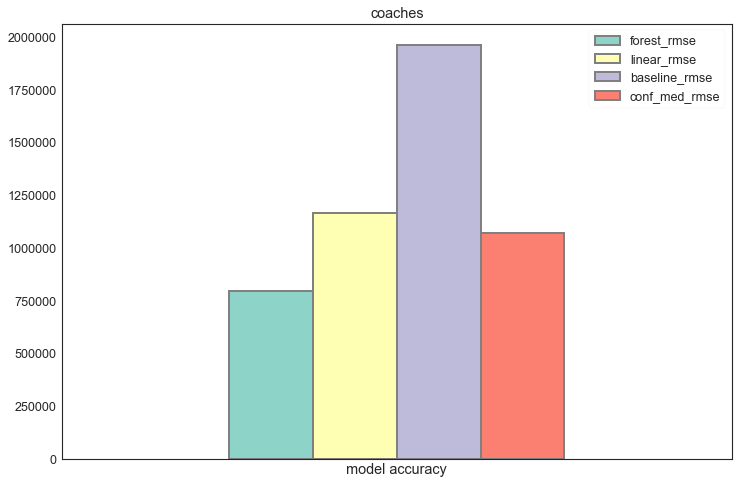

In [25]:
sns.set_palette('Set3')
sns.set_style('white')
rmse.plot(kind='bar', edgecolor='gray', linewidth=2, figsize=(12, 8))
plt.tick_params(
    axis='x',          
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.xlabel('model accuracy')
plt.title('coaches')
plt.show()

In [26]:
syracuse = grad_stads.loc[grad_stads.school == 'Syracuse']
syr_current = syracuse.totalpay.values[0]
syracuse = syracuse.drop('totalpay', axis=1)
train = grad_stads.drop(syracuse.index)
train_label = train.totalpay.copy()
train = train.drop('totalpay', axis=1)
train_prepped = pipe.fit_transform(train)
grid_search.fit(train_prepped, train_label)
syracuse_prepped = pipe.transform(syracuse)
syracuse_pred = grid_search.best_estimator_.predict(syracuse_prepped)


In [27]:
print('Predicted Syracuse pay:', '${:,.2f}'.format(np.round(syracuse_pred[0], 2)))
print('Syracuse current pay:', '${:,.2f}'.format(syr_current))

Predicted Syracuse pay: $3,533,205.18
Syracuse current pay: $2,401,206.00


In [28]:
conferences = train.conference.unique()
conf_pred = {}
for conference in conferences:
    syracuse.conference = conference
    temp_prep = pipe.transform(syracuse)
    conf_pred[conference] = grid_search.best_estimator_.predict(temp_prep)

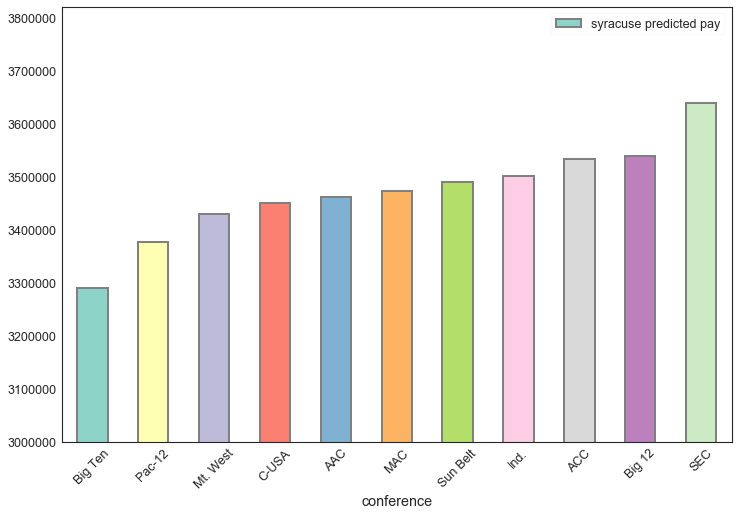

In [29]:
conf_pred_df = pd.DataFrame.from_dict(conf_pred)
conf_pred_df = pd.melt(conf_pred_df, var_name='conference', value_name='syracuse predicted pay')
conf_pred_df.sort_values(by='syracuse predicted pay', inplace=True)
conf_pred_df.plot(
    'conference', 'syracuse predicted pay', 
    kind='bar', figsize=(12,8), 
    edgecolor='gray', linewidth=2
)
plt.ylim(3000000)
plt.xticks(rotation=45)
plt.show()